# March Madness Model

Hello! Welcome to my first ever Machine Learning Project

March Madness is definitely the most exciting sporting event in the USA. A single elimination tournament provides a tense atmosphere for not only the players, but for the viewers as well. I have been creating brackets and competing in competitions with friends for about 12 years, usually just doing manual research through blogs and data sites like Kenpom and Barttorvik. 

This year, I will attempt to build my bracket using ML techniques that I have learned over the course of the past few months.

My goal in this model is two answer these two main questions  
1. Which teams will have the best chance of winning the tournament?  
2. Which teams, even if not winning the tournament, have the best chance of outperforming their expectation?

![display image](https://miro.medium.com/max/480/0*HUFnxDOqxPr1RsNy)

### Datasets

Data used in this analysis was uploaded by kaggle user andrewsundberg and contains CBB data from years 2015-2020  
https://www.kaggle.com/andrewsundberg/college-basketball-dataset?select=cbb.csv

In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [154]:
cbb = pd.read_csv('cbb.csv')
seed_history = pd.read_csv('MNCAAOverallSeeds.csv')
team_ids = pd.read_csv('MDataFiles_Stage1/MTeamSpellings.csv')

In [155]:
cbb['TEAM'] = cbb['TEAM'].str.lower()

In [156]:
data = pd.merge(cbb, team_ids, left_on='TEAM', right_on='TeamNameSpelling', how='left')
data = pd.merge(data, seed_history, left_on=['TeamID','YEAR'], right_on=['TeamID','Season'], how='left')

## Data Introduction

### Model Goal

From the data shown above, we have a lot of different metrics to attempt to calculate team performance. I envision that this the dataset can produce two different metrics to help with bracket predictions  

1. Overall Winner  
This is the main metric that this project will try to predict. The selection that is worth 50% of all potential points in the ESPN Bracket Challenge, where you will likely not win your bracket unless you select the champion correctly.  
  
  
2. Sleeper Teams  
Teams that probably will not be good enough to win the championship, but are predicted to outperform average performance based on seed. Identifying these teams can give you the extra point boost that can be the difference maker between you and others than predict the same champion

### Choosing a Model

**Input**  
Our data provides us with various team metrics and their past March Madness performance. This will be a **supervised algorithm**

**Output**  
We will be first training to predict an overall winner, using a modified version of the POSTSEASON column to do so. Although POSTSEASON is present as a categorical dataset, it is determined by the number of wins/round that a team achieves in a tournament. This means our output is a **quantitative discrete** output

However, it may be simpler to model with a continuous data output. We are not looking to classify each team as "Sweet 16" or a "Runner-up", we are just trying to find which teams have a best chance of winning the championship based off of past data. Because of this, it is okay for the output to be continuous.

Overall, my first choice at an algorithm is the simple **Linear Regression**

In [157]:
data.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,TeamNameSpelling,TeamID,Season,OverallSeed
0,north carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,36.2,71.7,8.6,2ND,1.0,2016,north carolina,1314.0,2016.0,2.0
1,wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,37.5,59.3,11.3,2ND,1.0,2015,wisconsin,1458.0,2015.0,4.0
2,michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,33.2,65.9,6.9,2ND,3.0,2018,michigan,1276.0,2018.0,11.0
3,texas tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,29.7,67.5,7.0,2ND,3.0,2019,texas tech,1403.0,2019.0,10.0
4,gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,29.0,71.5,7.7,2ND,1.0,2017,gonzaga,1211.0,2017.0,4.0


### Calculating Tourney Wins

This will be the predicted value of Point 1: Overall Winner. The round that each team has reached in March Madness in a given YEAR is represented in the POSTSEASON column. We will want to map this column to # of wins in tourney. We will also want to drop all rows with NA in POSTSEASON, these are the teams that did not qualify for March Madness and will not contribute to our analysis

In [158]:
win_map = {'R68':0, 'R64':0, 'R32':1, 'S16':2, 'E8':3, 'F4':4, '2ND':5, 'Champions':6}
data['MM_Wins'] = data['POSTSEASON'].map(win_map)
data.dropna(inplace = True)

### Calculating Wins over Expected Wins

This will be the predicted value of Point 2: Sleeper Teams. We first calculate a new parameter, Expected Wins, based off a team's seeding

Expected wins calculated from table taken from  
https://bracketodds.cs.illinois.edu/seedadv.html

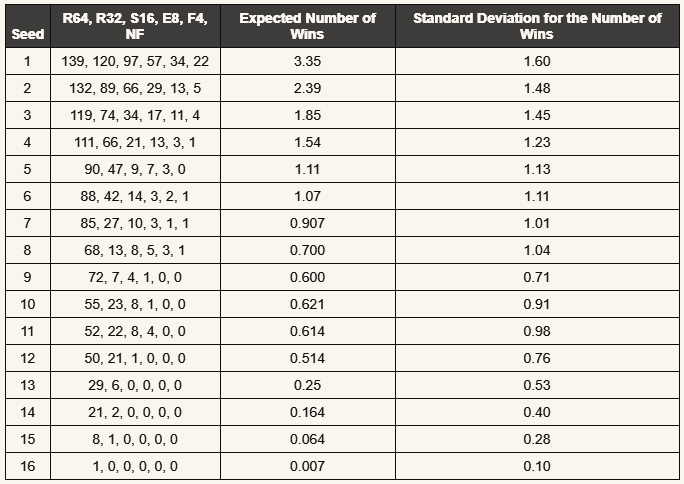

We then calculate the Wins_over_expected by taking the difference between actual MM wins and the Expected wins. The higher the value, the more likely this team will outperform their expected tourney run

In [159]:
expected_wins = pd.DataFrame({'Seed': range(1,17), 'Exp_Wins':[3.35,2.39,1.85,1.54,1.11,1.07,0.907,0.7,0.6,0.621,0.614,0.514,0.25,0.164,0.064,0.007]})
data = pd.merge(data, expected_wins, left_on='SEED', right_on='Seed', how='left')
data['Wins_over_expected'] = data['MM_Wins'] - data['Exp_Wins']

### Data Cleaning

We will want to drop columns that do not relate to Team statistics. Additionally, Win column will also be dropped because our data counts MM wins inside the W column, in which in future predictions will not already be summed in. Exp_Wins column will also need to be dropped because the analyzed value is dependent on it. All features need to be independent from one another in a linear regression model.

In [160]:
data.drop(['W','TEAM','CONF','G','POSTSEASON','SEED','YEAR','TeamNameSpelling','TeamID','Season','Exp_Wins'], axis=1, inplace=True)

In [161]:
data.corr()['MM_Wins']

ADJOE                 0.549131
ADJDE                -0.484196
BARTHAG               0.489840
EFG_O                 0.257036
EFG_D                -0.286426
TOR                  -0.231724
TORD                  0.041541
ORB                   0.189730
DRB                  -0.016852
FTR                  -0.104249
FTRD                 -0.198447
2P_O                  0.263829
2P_D                 -0.249419
3P_O                  0.132472
3P_D                 -0.172173
ADJ_T                -0.069796
WAB                   0.581178
OverallSeed          -0.598616
MM_Wins               1.000000
Seed                 -0.605842
Wins_over_expected    0.751646
Name: MM_Wins, dtype: float64

MAY REMOVE Here is a quick check of the correlation between the dataset

In [162]:
data.drop(['TORD','DRB','ADJ_T'], axis=1, inplace=True)

### Mean Normalization of Data
We want to make sure that the units for all parameters are weighted equally in the analysis. To do so, we will need to perform mean normalization and put the normalized values in a new dataframe: data_normed

In [163]:
data_normed = pd.DataFrame()
for column in data.columns[:-3]:
    data_normed[column] = (data[column] - data[column].mean()) / data[column].std()

In [164]:
data_normed

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,ORB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,WAB,OverallSeed
0,1.781179,-0.395955,0.918560,0.044398,0.033549,-1.131949,2.295278,-0.754346,-0.404574,0.796426,-0.789742,-1.371595,1.364665,1.416993,-1.647916
1,2.682947,-0.642844,1.049437,0.859563,-0.133824,-2.866828,0.229798,0.044930,-1.798165,1.095086,-0.755901,0.147616,1.984762,1.950779,-1.546144
2,0.397433,-1.250571,0.828618,0.526086,-0.133824,-1.941559,-1.355338,-1.082253,-0.474254,1.061902,-0.045254,-0.372114,-0.066328,1.080906,-1.189944
3,0.521814,-2.238127,1.013691,0.377875,-2.100454,0.198125,-0.899011,-0.631380,0.675459,0.431398,-1.703431,0.147616,-1.735820,1.100676,-1.240830
4,0.926055,-2.029221,1.032141,1.526517,-2.895474,-0.669314,-0.274564,0.618768,-1.014270,1.592853,-2.346398,0.827262,-2.069718,1.239065,-1.546144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,-0.100094,-0.433938,0.404852,-0.400238,-0.468569,1.065565,0.662108,-0.815828,-0.892331,0.331844,-0.417498,-1.291636,-0.352527,0.092415,-0.477543
334,0.941603,-0.073100,0.659112,-0.474344,0.786726,0.313784,1.334590,0.229378,0.065763,0.464582,0.834595,-1.691429,0.172171,1.159986,-1.189944
335,1.703441,-0.338981,0.893768,1.044828,0.033549,-0.900631,0.109712,-0.549403,0.379321,1.294193,-0.755901,0.227574,0.983067,1.674001,-1.495258
336,0.863864,-0.471921,0.749630,1.007775,-1.347276,-0.148851,0.229798,-0.323967,-0.805232,0.929164,-0.857422,0.667345,-1.449621,0.131955,0.489286


## Model #1, predicting the overall winner

### Baseline Trial

The easiest way someone can create and predict a bracket is to just have everyone from the higher seed advance. Are we able to beat this with our model?  

X - OverallSeed

#### Result
We use root mean squared error (RMSE) to evaluate our model  
RMSE - 0.990

In [165]:
X = data_normed
y = data['MM_Wins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
model = LinearRegression()
model.fit(np.array(X_train['OverallSeed']).reshape(-1,1),y_train)
Y_pred = model.predict(np.array(X_test['OverallSeed']).reshape(-1,1))

In [166]:
mean_squared_error(Y_pred,y_test)**(1/2)

0.9901336336463362

<AxesSubplot:ylabel='MM_Wins'>

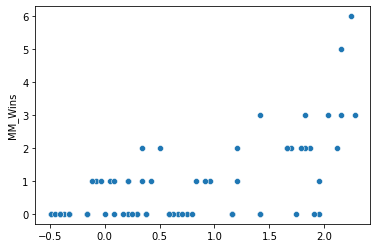

In [167]:
sns.scatterplot(x = Y_pred, y = y_test)

### Trial 1

To start off, I am aiming to perform a simple Linear Regession using all the factors in the our dataframe

X - all columns 
#### Result
RMSE - 0.800  

Our RMSE is smaller than our Baseline trial, suggesting that looking at all the parameters as a whole is more accurate at predict March Madness success than just the seed itself

In [168]:
model.fit(X_train,y_train)
Y_pred = model.predict(X_test)

In [169]:
mean_squared_error(Y_pred,y_test)**(1/2)

0.8002259772272506

<AxesSubplot:ylabel='MM_Wins'>

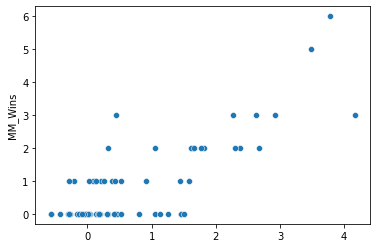

In [170]:
sns.scatterplot(x = Y_pred, y = y_test)

### Trial 2

I believe I am using too many parameters may be overfitting the dataset. In this trial, we will limit to the Top 5 parameters from the earlier correlation observed

X - ADJOE, ADJDE, BARTHAG, WAB, OverallSeed
#### Result
RMSE - 0.787  

Reducing the parameters that we are analyzing with makes the RMSE more accurate, however this does not mean we are at the model's optimal state yet

In [171]:
columns_t2 = ['ADJOE','ADJDE','BARTHAG','WAB']
model.fit(X_train[columns_t2],y_train)
Y_pred = model.predict(X_test[columns_t2])

In [172]:
mean_squared_error(Y_pred,y_test)**(1/2)

0.7785023296595734

<AxesSubplot:ylabel='MM_Wins'>

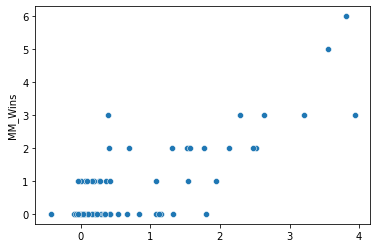

In [173]:
sns.scatterplot(x = Y_pred, y = y_test)

### Model Validation



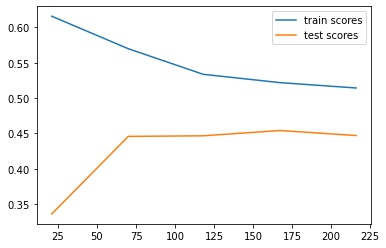

In [174]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train[columns_t2],y_train)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

sns.lineplot(x=train_sizes, y=train_scores_mean, label='train scores')
sns.lineplot(x=train_sizes, y=test_scores_mean, label='test scores')
plt.legend()

Learning Curve shows model that may have HIGH VARIANCE, which means our model may be overfitting. Overfitting is essentially when you algorithm is too tuned to your training data and does not apply to new data very well. The recommended paths forward for a learning curve with this pattern is:  

- Getting more training examples
- Trying smaller sets of features
- Increase regulization in linear regression
- Enabling cross validation in the model

Firstly, getting more training examples is difficult since this dataset is generated externally. Trying a smaller set of features may help, but we have already decreased the number of features earlier down to five. Currently, we are not performing any regularization on our model. The best path forward seems to be to add regularization through enabling cross validation and attempt to find the optimal amount of regularization. To do this, we first split the training set further into a training set and a cross validation set

In [175]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1)

In [176]:
alphas = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56]
train_rmse, valid_rmse = [], []

for alpha in alphas:
    reg_model = Lasso(alpha = alpha)
    reg_model.fit(X_train[columns_t2], y_train)
    train_pred = reg_model.predict(X_train[columns_t2])
    valid_pred = reg_model.predict(X_valid[columns_t2])
    train_rmse.append(mean_squared_error(y_train, train_pred)**(1/2))
    valid_rmse.append(mean_squared_error(y_valid, valid_pred)**(1/2))

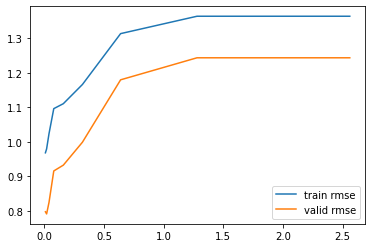

In [177]:
sns.lineplot(x = alphas, y = train_rmse, label='train rmse')
sns.lineplot(x = alphas, y = valid_rmse, label='valid rmse')
plt.legend()

Initially, it was seen that the model was Overfitting. However, it is shown here that adding regularization to the model actually hurts the model and increases the RMSE. Therefore, I am content with sticking with the original model without regularization.

## Model #2, predicting overperformers

The second model will attempt to predict teams that will have a good chance to outperform their seed in the tournament, creating good opportunities for the user to gain additional points in the bracket challenge by selecting these teams to go farther than others

To start, we'll look at the correlation of variation parameters to wins over expected

In [178]:
data.corr()['Wins_over_expected']

ADJOE                 0.086239
ADJDE                -0.109832
BARTHAG               0.059041
EFG_O                 0.062452
EFG_D                -0.057102
TOR                  -0.049616
ORB                  -0.003153
FTR                  -0.077534
FTRD                 -0.027766
2P_O                  0.093800
2P_D                 -0.024055
3P_O                 -0.021967
3P_D                 -0.064487
WAB                   0.024261
OverallSeed          -0.006196
MM_Wins               0.751646
Seed                 -0.007179
Wins_over_expected    1.000000
Name: Wins_over_expected, dtype: float64

At first glance, the correlation between various parameters and wins over expected is a lot weaker than it was when correlating to MM_Wins. This is expected, as there is more volatility to this parameter.  

### Trial 1

We'll first start with all the parameters, like we did last time  

#### Result
RMSE - 0.857

In [179]:
X = data_normed
y = data['Wins_over_expected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
model = LinearRegression()
model.fit(np.array(X_train['OverallSeed']).reshape(-1,1),y_train)
Y_pred = model.predict(np.array(X_test['OverallSeed']).reshape(-1,1))

In [180]:
mean_squared_error(Y_pred,y_test)**(1/2)

0.8573740097820703

<AxesSubplot:ylabel='Wins_over_expected'>

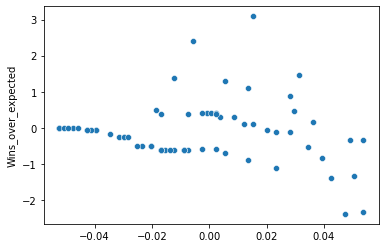

In [181]:
sns.scatterplot(x = Y_pred, y = y_test)

In [183]:
columns_t2 = ['ADJOE','ADJDE','2P_O','FTR','3P_D']
model.fit(X_train[columns_t2],y_train)
Y_pred = model.predict(X_test[columns_t2])

In [184]:
mean_squared_error(Y_pred,y_test)**(1/2)

0.9026956523692887

<AxesSubplot:ylabel='Wins_over_expected'>

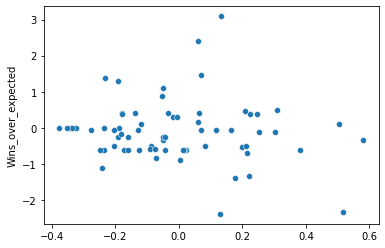

In [185]:
sns.scatterplot(x = Y_pred, y = y_test)

### Model Validation

The scores outputted by the training and test set are very low, and there is little correlation to be found with our current dataset to predict wins over expected. It would be difficult to improve the model with the current dataset that we are using. In the next section, I outline potential paths to adding data that can improve the robustness of this model

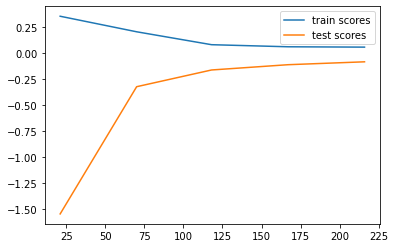

In [186]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train[columns_t2],y_train)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

sns.lineplot(x=train_sizes, y=train_scores_mean, label='train scores')
sns.lineplot(x=train_sizes, y=test_scores_mean, label='test scores')
plt.legend()

### Potential Future Improvements to Model

Overall, the analysis done in this project is still at a basic level. March madness has a lot of unpredictability and factors that are not captured in the initial dataset that we used. To really hone in and improve the model, there are a few ideas on additional paths to take:

1. Additional Data  
To improve the model, we can gather additional miscellaneous information into our dataset. From my history of reading blogs, additional characteristics of teams that have outperformed expectations in the tournament are:
- Coach's historical record in March Madness
- Seniority of starting lineup (more juniors and seniors)
- Experienced point guard
- Game locations

2. Using Pre-Tournament Data  
Data used is calculated post-tournament. Therefore, the games that teams play and win during March Madness are already added into the dataset. This improves metrics for the winning teams and falsely helps the model in predicting March Madness wins. Since a model like this is intended to be used pre-tournament, it would be more accurate to use data for teams without tournament games included.  
  
  
3. Relating Results to Prediction Percentage  
If you compete in a Bracket Challenge, picking the statistically likely winner in every game does not maximize your chance of winning in first place. For example, in 2019 Duke was the overwhelming people's choice favorite to win the championship with about 38% of people picking Duke to win it all on ESPN. Models also thought Duke was the favorite as well, giving them the slight edge over Virginia, which only 8% of people picked to win it all. However, even if Duke wins, you still need to compete with the large number of other people who also picked Duke in other games. Picking a team like Virginia which has a good chance of winning, but is a less popular pick, allows you to compete with less people on other games if in fact they do win. Maximizing your chance of winning a bracket is dependant on the brackets you are competing against.  
  
  
4. Opponent Analysis  
Some teams match up better against other teams and their performance is influenced by which opponents they will face in the tournament. Teams can get weaker opponents if their opponent is overseeded and therefore have a higher chance of winning. This will not matter if the team is expected to perform well or not. Additionally, there are more specific matchup related details about how teams play (f.e. zone or man-to-man defense) that I am not knowledgeable enough to delve into further